This script is to test the signal change in wet versus dry days in 2024. We will begin with simple VOD (as and aa), then separate days of precipitation, then plot

Starting with 5.7, then 1.7, then 1.3, then 1.2, then all 

In [1]:
#Chunk that sloads necessary packages & sets working environment to where the jupyterlab notebook file is 
%load_ext autoreload
%autoreload 2
import gnssvod as gv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pdb
import importlib
import zipfile
import os
import xarray as xr
import glob
import shutil
from gnssvod.hemistats.hemistats import hemibuild
#import georinex as gr
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates
import shutil
from matplotlib import rcParams
from datetime import datetime, timedelta

In [2]:
#pairing and concatenating--- starting by establishing path to .nc files per station
##here MACROCOSM 5 & 1 are references
# MACROCOSM 3 is located in- gutter
#MACROCOSM 2 is located in- drought
#MACROCOSM-7 is located in- coffe1 
pattern={'MACROCOSM-1':'/Volumes/coraldelmar/all_data/MACROCOSM-1/nc/*.nc',
        'MACROCOSM-2':'/Volumes/coraldelmar/all_data/MACROCOSM-2/nc/*.nc',
        'MACROCOSM-3':'/Volumes/coraldelmar/all_data/MACROCOSM-3/nc/*.nc',
        'MACROCOSM-5':'/Volumes/coraldelmar/all_data/MACROCOSM-5/nc/*.nc',
        'MACROCOSM-7':'/Volumes/coraldelmar/all_data/MACROCOSM-7/nc/*.nc'}

In [3]:
#setting time intervals
startday = start=pd.to_datetime('01-01-2025',format='%d-%m-%Y')
timeintervals=pd.interval_range(start=startday, periods=365, freq='D', closed='left')
timeintervals

IntervalIndex([[2025-01-01 00:00:00, 2025-01-02 00:00:00),
               [2025-01-02 00:00:00, 2025-01-03 00:00:00),
               [2025-01-03 00:00:00, 2025-01-04 00:00:00),
               [2025-01-04 00:00:00, 2025-01-05 00:00:00),
               [2025-01-05 00:00:00, 2025-01-06 00:00:00),
               [2025-01-06 00:00:00, 2025-01-07 00:00:00),
               [2025-01-07 00:00:00, 2025-01-08 00:00:00),
               [2025-01-08 00:00:00, 2025-01-09 00:00:00),
               [2025-01-09 00:00:00, 2025-01-10 00:00:00),
               [2025-01-10 00:00:00, 2025-01-11 00:00:00),
               ...
               [2025-12-22 00:00:00, 2025-12-23 00:00:00),
               [2025-12-23 00:00:00, 2025-12-24 00:00:00),
               [2025-12-24 00:00:00, 2025-12-25 00:00:00),
               [2025-12-25 00:00:00, 2025-12-26 00:00:00),
               [2025-12-26 00:00:00, 2025-12-27 00:00:00),
               [2025-12-27 00:00:00, 2025-12-28 00:00:00),
               [2025-12-28 00:00:00, 

In [4]:
#opening paired files as a df
ds=xr.open_mfdataset('/Volumes/coraldelmar/all_data/MACROCOSM-5.7/*.nc',combine='nested',concat_dim='Epoch')
ds

<xarray.Dataset> Size: 5GB
Dimensions:    (Station: 2, Epoch: 432688, SV: 120)
Coordinates:
  * Station    (Station) <U11 88B 'MACROCOSM-5' 'MACROCOSM-7'
  * SV         (SV) <U3 1kB 'C11' 'C12' 'C14' 'C19' ... 'R24' 'R25' 'R26' 'R27'
  * Epoch      (Epoch) datetime64[ns] 3MB 2023-05-08T12:18:30 ... 2025-06-06T...
Data variables:
    S1C        (Station, Epoch, SV) float64 831MB dask.array<chunksize=(1, 11, 3), meta=np.ndarray>
    S1X        (Station, Epoch, SV) float64 831MB dask.array<chunksize=(1, 11, 3), meta=np.ndarray>
    S2C        (Station, Epoch, SV) float64 831MB dask.array<chunksize=(1, 11, 3), meta=np.ndarray>
    S2X        (Station, Epoch, SV) float64 831MB dask.array<chunksize=(1, 11, 3), meta=np.ndarray>
    Azimuth    (Station, Epoch, SV) float64 831MB dask.array<chunksize=(1, 11, 3), meta=np.ndarray>
    Elevation  (Station, Epoch, SV) float64 831MB dask.array<chunksize=(1, 11, 3), meta=np.ndarray>

In [5]:
#creating df
df=ds.to_dataframe().dropna(how='all').reorder_levels(["Station","Epoch","SV"]).sort_index()
df

S1C   S1X   S2C  S2X  Azimuth  Elevation
Station     Epoch               SV                                            
MACROCOSM-5 2023-05-08 12:18:30 C11   NaN   NaN   NaN  NaN   -162.3       52.0
                                C12   NaN   NaN   NaN  NaN     58.2       67.1
                                C24   NaN   NaN   NaN  NaN     46.2       54.3
                                C34   NaN   NaN   NaN  NaN   -175.4       74.4
                                E14   NaN  46.0   NaN  NaN   -109.8       68.7
...                                   ...   ...   ...  ...      ...        ...
MACROCOSM-7 2025-06-04 12:46:30 R13  35.8   NaN   NaN  NaN      NaN        NaN
                                R14  41.1   NaN  37.2  NaN    -30.3       42.9
                                R17  28.2   NaN  25.7  NaN   -102.3       22.3
                                R23  25.2   NaN   NaN  NaN      NaN        NaN
                                R24  35.4   NaN  32.7  NaN    -40.0       46.6

[14541683 rows x 6 columns]

In [6]:
hemi=gv.hemibuild(4)
hemi

In [7]:
hemi.grid

,azi,ele,azimin,azimax,elemin,elemax
CellID,,,,,,
0,0.000000,90.0,0.000000,360.000000,88.0,90.0
1,22.500000,86.0,0.000000,45.000000,84.0,88.0
2,67.500000,86.0,45.000000,90.000000,84.0,88.0
3,112.500000,86.0,90.000000,135.000000,84.0,88.0
4,157.500000,86.0,135.000000,180.000000,84.0,88.0
...,...,...,...,...,...,...
1523,345.789474,6.0,344.210526,347.368421,4.0,8.0
1524,348.947368,6.0,347.368421,350.526316,4.0,8.0
1525,352.105263,6.0,350.526316,353.684211,4.0,8.0


In [8]:
patches=hemi.patches()
patches

CellID
0       Rectangle(xy=(0, 0), width=6.28319, height=2, ...
1       Rectangle(xy=(0, 2), width=0.785398, height=4,...
2       Rectangle(xy=(0.785398, 2), width=0.785398, he...
3       Rectangle(xy=(1.5708, 2), width=0.785398, heig...
4       Rectangle(xy=(2.35619, 2), width=0.785398, hei...
                              ...                        
1523    Rectangle(xy=(6.00761, 82), width=0.0551157, h...
1524    Rectangle(xy=(6.06272, 82), width=0.0551157, h...
1525    Rectangle(xy=(6.11784, 82), width=0.0551157, h...
1526    Rectangle(xy=(6.17295, 82), width=0.0551157, h...
1527    Rectangle(xy=(6.22807, 82), width=0.0551157, h...
Name: Patches, Length: 1528, dtype: object

In [9]:
newdf=hemi.add_CellID(df)

In [10]:
newdf

S1C   S1X   S2C   S2X  Azimuth  \
Station     Epoch               SV                                     
MACROCOSM-5 2023-05-08 12:18:30 C11   NaN   NaN   NaN   NaN   -162.3   
                                C12   NaN   NaN   NaN   NaN     58.2   
                                C24   NaN   NaN   NaN   NaN     46.2   
                                C34   NaN   NaN   NaN   NaN   -175.4   
                                E14   NaN  46.0   NaN   NaN   -109.8   
...                                   ...   ...   ...   ...      ...   
MACROCOSM-7 2025-06-04 12:46:30 G30  27.0   NaN   NaN  18.0   -138.3   
                                R12  18.2   NaN   NaN   NaN    155.4   
                                R14  41.1   NaN  37.2   NaN    -30.3   
                                R17  28.2   NaN  25.7   NaN   -102.3   
                                R24  35.4   NaN  32.7   NaN    -40.0   

                                     Elevation  CellID  
Station     Epoch               SV                      
MACROCOSM-5 2023-05-08 12:18:30 C11       52.0     389  
                                C12       67.1     127  
                                C24       54.3     290  
                                C34       74.4      65  
                                E14       68.7     108  
...                                        ...     ...  
MACROCOSM-7 2025-06-04 12:46:30 G30       40.2     555  
                                R12       23.2    1020  
                                R14       42.9     580  
                                R17       22.3    1050  
                                R24       46.6     494  

[13407120 rows x 7 columns]

In [11]:
hemi_average=newdf.groupby(['CellID','Station']).mean()
hemi_average

S1C        S1X        S2C        S2X    Azimuth  \
CellID Station                                                              
0      MACROCOSM-5  47.324126  45.092201  41.259025  45.263692  24.282766   
       MACROCOSM-7  41.197580  40.952541  36.500261  39.635079  28.612138   
1      MACROCOSM-5  47.026198  45.300246  40.833992  45.204639  21.943306   
       MACROCOSM-7  43.798986  41.951070  36.109975  40.570342  19.914197   
2      MACROCOSM-5  46.629013  45.277232  41.274956  44.374689  66.309234   
...                       ...        ...        ...        ...        ...   
1523   MACROCOSM-5        NaN  25.483333        NaN        NaN -14.244444   
1524   MACROCOSM-5        NaN  25.580328        NaN        NaN -11.044444   
1525   MACROCOSM-5        NaN  27.587356        NaN        NaN  -7.761364   
1526   MACROCOSM-5        NaN  31.192174        NaN        NaN  -4.808696   
1527   MACROCOSM-5        NaN  34.715315        NaN        NaN  -1.566667   

                    Elevation  
CellID Station                 
0      MACROCOSM-5  88.640707  
       MACROCOSM-7  88.624194  
1      MACROCOSM-5  85.763443  
       MACROCOSM-7  85.862252  
2      MACROCOSM-5  85.963814  
...                       ...  
1523   MACROCOSM-5   5.300000  
1524   MACROCOSM-5   5.334921  
1525   MACROCOSM-5   5.221591  
1526   MACROCOSM-5   5.183478  
1527   MACROCOSM-5   5.296396  

[2914 rows x 6 columns]

In [12]:
hemi_average[['S1C', 'S1X', 'S2X']].isna().sum()
hemi_average = hemi_average.dropna(subset=['S1C','S1X','S2C','S2X'])

In [13]:
hemi_average

S1C        S1X        S2C        S2X    Azimuth  \
CellID Station                                                              
0      MACROCOSM-5  47.324126  45.092201  41.259025  45.263692  24.282766   
       MACROCOSM-7  41.197580  40.952541  36.500261  39.635079  28.612138   
1      MACROCOSM-5  47.026198  45.300246  40.833992  45.204639  21.943306   
       MACROCOSM-7  43.798986  41.951070  36.109975  40.570342  19.914197   
2      MACROCOSM-5  46.629013  45.277232  41.274956  44.374689  66.309234   
...                       ...        ...        ...        ...        ...   
1514   MACROCOSM-7  25.211592  24.403855  17.500000  20.314413 -42.606151   
1515   MACROCOSM-5  28.192760  27.597756  22.747024  25.085224 -39.067710   
       MACROCOSM-7  24.784942  23.979420  22.513043  20.848589 -39.090674   
1516   MACROCOSM-5  28.380739  27.622027  25.310782  23.528903 -36.629170   
       MACROCOSM-7  24.094947  24.142545  21.725860  20.589272 -36.639070   

                    Elevation  
CellID Station                 
0      MACROCOSM-5  88.640707  
       MACROCOSM-7  88.624194  
1      MACROCOSM-5  85.763443  
       MACROCOSM-7  85.862252  
2      MACROCOSM-5  85.963814  
...                       ...  
1514   MACROCOSM-7   6.233591  
1515   MACROCOSM-5   6.428845  
       MACROCOSM-7   6.377787  
1516   MACROCOSM-5   6.129538  
       MACROCOSM-7   6.105321  

[2120 rows x 6 columns]

In [14]:
pattern='/Volumes/coraldelmar/all_data/MACROCOSM-5.7/*.nc'
pairings={'MACROCOSM-5.7':('MACROCOSM-5','MACROCOSM-7')}
bands={'VOD1':['S1C','S1X'],'VOD2':['S2C','S2X']}
vod=gv.calc_vod(pattern,pairings,bands)
vod=vod['MACROCOSM-5.7']
vod

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-01-14 00:00:00 C11       NaN       NaN    -71.0       14.7
                    C12       NaN       NaN    -18.4       41.6
                    C21       NaN       NaN    150.9       38.2
                    C22       NaN       NaN     82.1       36.3
                    C24       NaN       NaN   -115.8       48.2
...                           ...       ...      ...        ...
2025-01-22 23:59:30 R05  1.861875  1.456467    113.0       40.7
                    R09  2.344999  3.045454   -142.9       41.4
                    R10       NaN       NaN      NaN        NaN
                    R11       NaN  0.220617    -33.9        8.1
                    R20  0.046191  0.046191    -17.9       30.1

[2934782 rows x 4 columns]

In [15]:
#
vod = vod.reset_index()

#
azimuth_mask = (vod['Azimuth'] >= 0) & (vod['Azimuth'] <= 70)
vod = vod[azimuth_mask]

#
vod = vod.set_index(['Epoch', 'SV'])

# 
vod = vod.sort_index()

In [16]:
vod[['VOD1','VOD2']].isna().sum()
vod = vod.dropna(subset=['VOD1','VOD2'])
vod

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-01-11 17:13:30 G27 -0.286711 -1.058625     36.1       73.3
                    R11 -0.205109  0.337826      4.3       31.6
2025-01-11 17:14:00 G26 -0.599508  0.251145     52.3       20.6
                    G27 -0.110157 -0.638912     35.7       73.1
                    R11 -0.193044  0.301631      4.6       31.6
...                           ...       ...      ...        ...
2025-05-04 14:39:00 R24  1.144421  0.996070     15.9       27.4
2025-05-04 14:39:30 G01  1.173779  1.382450     32.1       34.5
                    R24  0.842005  0.999882     16.1       27.2
2025-05-04 14:40:00 G01  2.089082  2.283717     32.1       34.3
                    R24  1.090888  0.660826     16.3       27.1

[298859 rows x 4 columns]

In [17]:
hemi=gv.hemibuild(2)
patches=hemi.patches()
vod=hemi.add_CellID(vod).drop(columns=['Azimuth','Elevation'])
vod_avg=vod.groupby(['CellID']).agg(['mean','std','count'])
vod_avg.columns=["_".join(x) for x in vod_avg.columns.to_flat_index()]
vod_avg

,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count
CellID,,,,,,
0,0.846120,0.353045,16,1.063410,0.368792,16
1,1.031465,0.639593,304,0.947107,0.594692,304
2,0.684706,0.610214,258,0.782013,0.495909,258
9,0.688948,0.503597,391,0.888999,0.819576,391
10,0.795086,0.664142,314,0.692287,0.728724,314
...,...,...,...,...,...,...
6236,0.007178,0.039128,154,-0.016557,0.035726,154
6237,0.041789,0.048152,28,-0.016040,0.051042,28
6238,0.017803,0.042097,45,-0.006421,0.033615,45


In [18]:
vod[['VOD1','VOD2']].isna().sum()
vod = vod.dropna(subset=['VOD1','VOD2'])
vod

VOD1      VOD2  CellID
Epoch               SV                             
2025-01-11 17:13:30 G27 -0.286711 -1.058625     230
                    R11 -0.205109  0.337826    2991
2025-01-11 17:14:00 G26 -0.599508  0.251145    4241
                    G27 -0.110157 -0.638912     230
                    R11 -0.193044  0.301631    2991
...                           ...       ...     ...
2025-05-04 14:39:00 R24  1.144421  0.996070    3389
2025-05-04 14:39:30 G01  1.173779  1.382450    2815
                    R24  0.842005  0.999882    3390
2025-05-04 14:40:00 G01  2.089082  2.283717    2815
                    R24  1.090888  0.660826    3390

[298822 rows x 3 columns]

In [19]:
vod_anom=vod.join(vod_avg,on='CellID')
vod_anom

VOD1      VOD2  CellID  VOD1_mean  VOD1_std  \
Epoch               SV                                                     
2025-01-11 17:13:30 G27 -0.286711 -1.058625     230  -0.167976  0.703139   
                    R11 -0.205109  0.337826    2991   0.137429  0.706969   
2025-01-11 17:14:00 G26 -0.599508  0.251145    4241   0.270404  0.407073   
                    G27 -0.110157 -0.638912     230  -0.167976  0.703139   
                    R11 -0.193044  0.301631    2991   0.137429  0.706969   
...                           ...       ...     ...        ...       ...   
2025-05-04 14:39:00 R24  1.144421  0.996070    3389  -0.122483  0.581987   
2025-05-04 14:39:30 G01  1.173779  1.382450    2815   1.469311  0.524707   
                    R24  0.842005  0.999882    3390   0.325666  0.602226   
2025-05-04 14:40:00 G01  2.089082  2.283717    2815   1.469311  0.524707   
                    R24  1.090888  0.660826    3390   0.325666  0.602226   

                         VOD1_count  VOD2_mean  VOD2_std  VOD2_count  
Epoch               SV                                                
2025-01-11 17:13:30 G27         349  -0.521988  0.671082         349  
                    R11         731   0.022942  0.552361         731  
2025-01-11 17:14:00 G26         510   0.330860  0.423819         510  
                    G27         349  -0.521988  0.671082         349  
                    R11         731   0.022942  0.552361         731  
...                             ...        ...       ...         ...  
2025-05-04 14:39:00 R24        1004   0.540969  0.584034        1004  
2025-05-04 14:39:30 G01         890   1.438271  0.590865         890  
                    R24         470   0.682345  0.475719         470  
2025-05-04 14:40:00 G01         890   1.438271  0.590865         890  
                    R24         470   0.682345  0.475719         470  

[298822 rows x 9 columns]

In [20]:
vod_anom['VOD1_anom']=vod_anom['VOD1']-vod_anom['VOD1_mean']
vod_anom['VOD2_anom']=vod_anom['VOD2']-vod_anom['VOD2_mean']

In [21]:
vod_ts=vod_anom.groupby(pd.Grouper(freq='1h',level='Epoch')).mean()
vod_ts

,VOD1,VOD2,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,VOD1_anom,VOD2_anom
Epoch,,,,,,,,,,,
2025-01-11 17:00:00,0.080690,0.236541,1994.920354,0.279482,0.674311,511.256637,0.459416,0.673579,511.256637,-0.198793,-0.222875
2025-01-11 18:00:00,0.974600,0.886946,2598.955381,1.085643,0.607491,595.469816,1.072874,0.593446,595.469816,-0.111042,-0.185928
2025-01-11 19:00:00,0.674697,0.750667,2394.811856,0.782684,0.579978,675.381443,0.849428,0.552816,675.381443,-0.107988,-0.098761
2025-01-11 20:00:00,0.522121,0.735736,3031.270270,0.560758,0.511272,519.423423,0.598070,0.514225,519.423423,-0.038637,0.137667
2025-01-11 21:00:00,0.805476,0.953385,2721.978836,0.857555,0.554177,504.169312,0.928910,0.507365,504.169312,-0.052080,0.024475
...,...,...,...,...,...,...,...,...,...,...,...
2025-05-04 10:00:00,3.616433,3.190655,1089.121212,0.571660,0.726516,641.545455,0.891706,0.628373,641.545455,3.044773,2.298949
2025-05-04 11:00:00,0.837626,1.019436,2676.823529,0.704715,0.621516,660.637255,0.972931,0.554726,660.637255,0.132911,0.046505
2025-05-04 12:00:00,1.133702,1.034610,2878.603604,0.981279,0.550474,825.774775,1.044347,0.565130,825.774775,0.152423,-0.009738


In [22]:
#
plt.rcParams["font.family"] = "Times New Roman"

#precip data load
precip_df = pd.read_excel("/Volumes/coraldelmar/weather.station_alonso/2025/precip05.xlsx")

# Parse full datetime with hour info directly
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)

# Extract hour from timestamp
precip_df['hour'] = precip_df['Timestamp'].dt.hour

# Group total precipitation by hour
precip_hourly = precip_df.groupby('hour')['Rain_mm_Tot'].sum()
precip_hourly = precip_hourly.reindex(range(24), fill_value=0)  # ensure 0–23 coverage


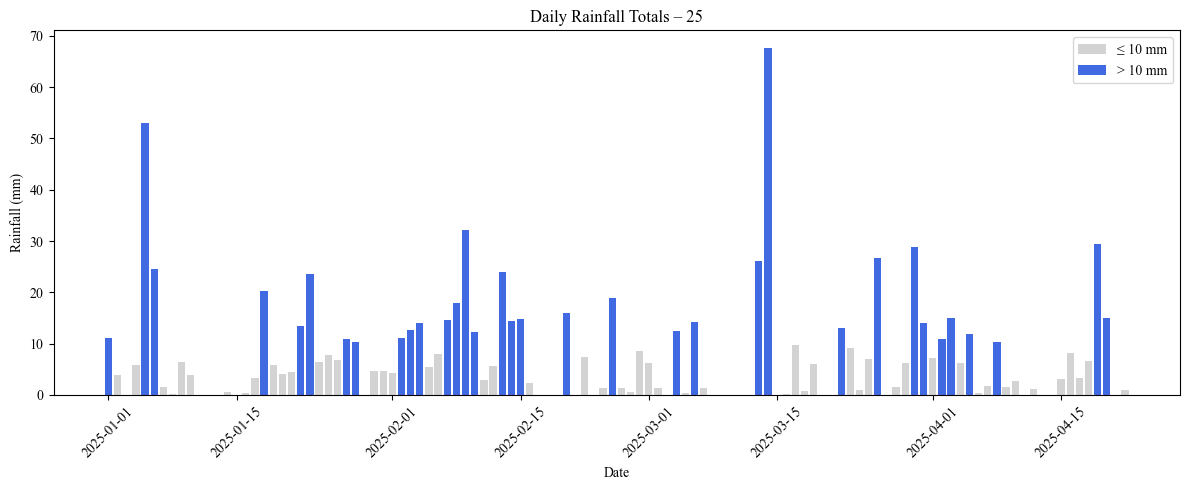

In [23]:

plt.rcParams["font.family"] = "Times New Roman"

# Parse datetime
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)

# Extract date
precip_df['Date'] = precip_df['Timestamp'].dt.date

# Group by date
precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()

# Separate days by rainfall amount
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]

# 
fig, ax = plt.subplots(figsize=(12, 5))

#  dry days
ax.bar(dry_days['Date'], dry_days['Rain_mm_Tot'], color='lightgray', label='≤ 10 mm')
#  wet days
ax.bar(wet_days['Date'], wet_days['Rain_mm_Tot'], color='royalblue', label='> 10 mm')

ax.set_title("Daily Rainfall Totals – 25")
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall (mm)")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# 
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()

# 
precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'], utc=False)

#  wet and dry days
wet_days = pd.to_datetime(precip_daily.loc[precip_daily['Rain_mm_Tot'] > 10, 'Date'], utc=False)
dry_days = pd.to_datetime(precip_daily.loc[precip_daily['Rain_mm_Tot'] <= 10, 'Date'], utc=False)

# 
vod_ts.index = pd.to_datetime(vod_ts.index, utc=False)
vod_ts['Date'] = vod_ts.index.normalize()

# example dates
print("Example VOD dates:", vod_ts['Date'].unique()[:5])
print("Example wet_days:", wet_days[:5].values)
print("Overlap count (wet):", vod_ts['Date'].isin(wet_days).sum())
print("Overlap count (dry):", vod_ts['Date'].isin(dry_days).sum())

# Assign labels
vod_ts['wetdry'] = 'none'
vod_ts.loc[vod_ts['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts.loc[vod_ts['Date'].isin(dry_days), 'wetdry'] = 'dry'

print(vod_ts['wetdry'].value_counts())


Example VOD dates: <DatetimeArray>
['2025-01-11 00:00:00', '2025-01-12 00:00:00', '2025-01-13 00:00:00',
 '2025-01-14 00:00:00', '2025-01-15 00:00:00']
Length: 5, dtype: datetime64[ns]
Example wet_days: ['2025-01-01T00:00:00.000000000' '2025-01-05T00:00:00.000000000'
 '2025-01-06T00:00:00.000000000' '2025-01-18T00:00:00.000000000'
 '2025-01-22T00:00:00.000000000']
Overlap count (wet): 744
Overlap count (dry): 1687
wetdry
dry     1687
wet      744
none     279
Name: count, dtype: int64


wetdry
dry     1687
wet      744
none     279
Name: count, dtype: int64


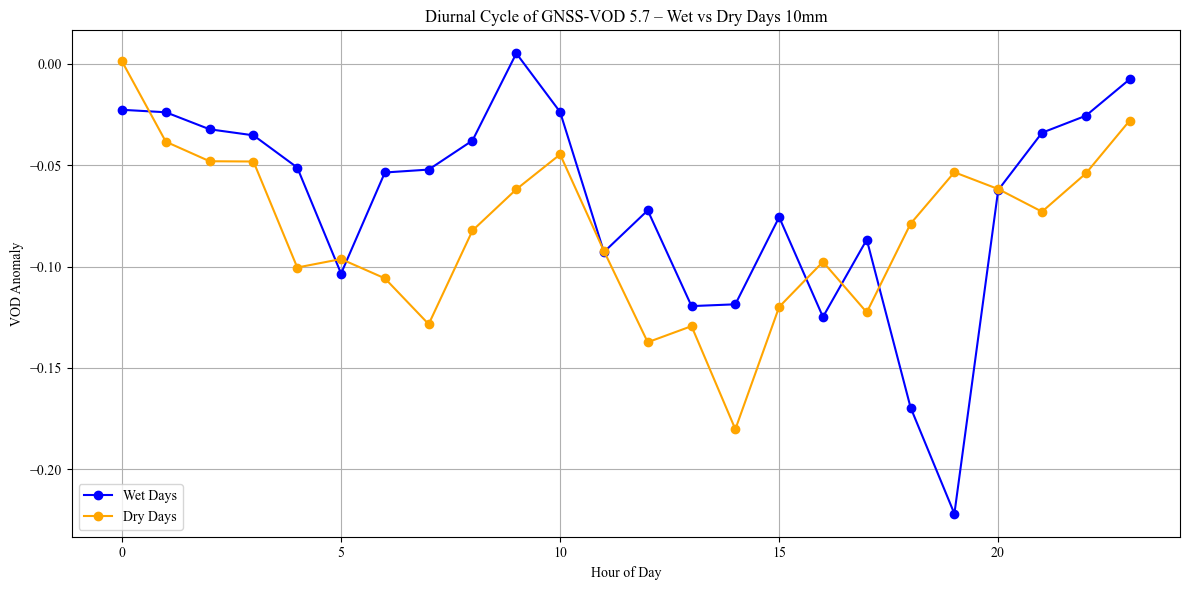

In [25]:
# 
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()  # This keeps full datetime, just zeroes the time

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()

# 
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

# 
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# 
vod_ts.index = pd.to_datetime(vod_ts.index)
vod_ts['Date'] = vod_ts.index.normalize()

vod_ts['wetdry'] = 'none'
vod_ts.loc[vod_ts['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts.loc[vod_ts['Date'].isin(dry_days), 'wetdry'] = 'dry'

# 
print(vod_ts['wetdry'].value_counts())

# 
wet_data = vod_ts[vod_ts['wetdry'] == 'wet']
dry_data = vod_ts[vod_ts['wetdry'] == 'dry']

wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))

wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')

ax.set_title("Diurnal Cycle of GNSS-VOD 5.7 – Wet vs Dry Days 10mm")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


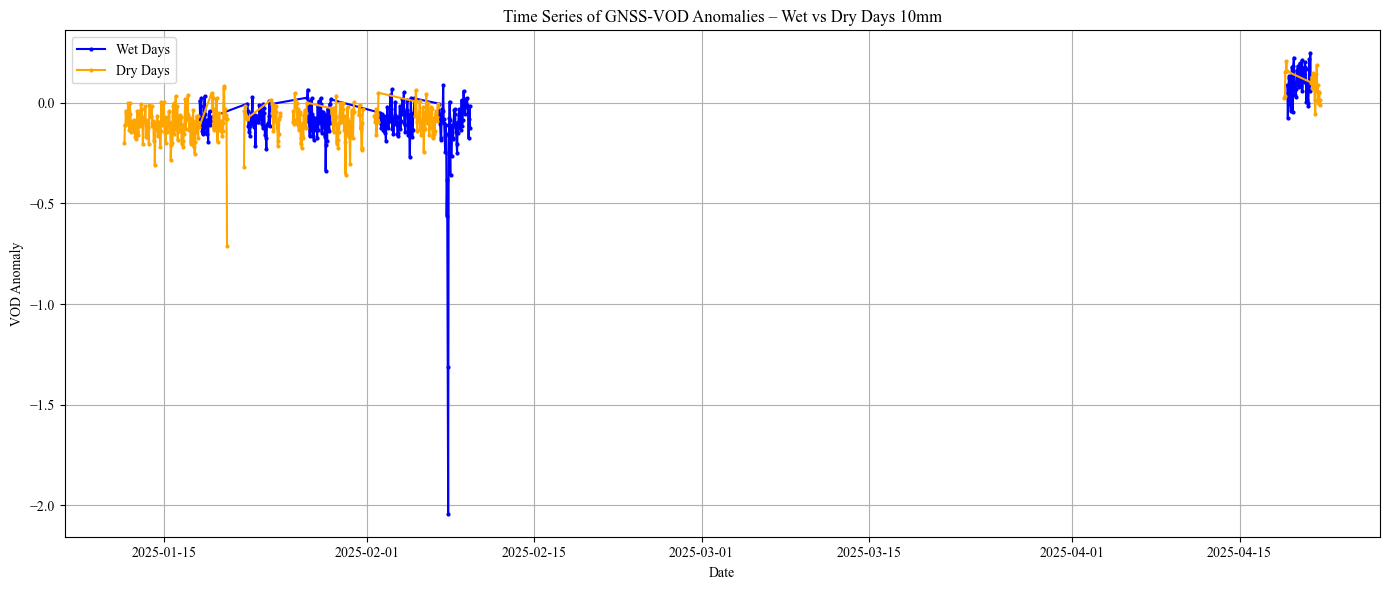

In [26]:
#
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

#
vod_ts.index = pd.to_datetime(vod_ts.index)
vod_ts['Date'] = vod_ts.index.normalize()

vod_ts['wetdry'] = 'none'
vod_ts.loc[vod_ts['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts.loc[vod_ts['Date'].isin(dry_days), 'wetdry'] = 'dry'

#
wet_data = vod_ts[vod_ts['wetdry'] == 'wet']
dry_data = vod_ts[vod_ts['wetdry'] == 'dry']

# 
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(wet_data.index, wet_data['VOD1_anom'], label='Wet Days', color='blue', linestyle='-', marker='o', markersize=2)
ax.plot(dry_data.index, dry_data['VOD1_anom'], label='Dry Days', color='orange', linestyle='-', marker='o', markersize=2)

ax.set_title("Time Series of GNSS-VOD Anomalies – Wet vs Dry Days 10mm")
ax.set_xlabel("Date")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


now reference 1, station 7

In [27]:
#opening paired files as a df
ds17=xr.open_mfdataset('/Volumes/coraldelmar/all_data/MACROCOSM-1.7/*.nc',combine='nested',concat_dim='Epoch')
ds17

<xarray.Dataset> Size: 8GB
Dimensions:    (Station: 2, Epoch: 645059, SV: 123)
Coordinates:
  * Station    (Station) <U11 88B 'MACROCOSM-1' 'MACROCOSM-7'
  * SV         (SV) <U3 1kB 'C11' 'C12' 'C14' 'C19' ... 'R26' 'R27' 'S31' 'S33'
  * Epoch      (Epoch) datetime64[ns] 5MB 2023-01-10T19:07:30 ... 2025-06-09T...
Data variables:
    S1C        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    S1X        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    S2C        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    S2X        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    Azimuth    (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    Elevation  (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>

In [28]:
df17=ds17.to_dataframe().dropna(how='all').reorder_levels(["Station","Epoch","SV"]).sort_index()
df17

S1C  S1X   S2C  S2X  Azimuth  Elevation
Station     Epoch               SV                                           
MACROCOSM-1 2023-01-10 19:07:30 C35   NaN  NaN   NaN  NaN     99.5       62.1
                                G04  31.0  NaN   NaN  NaN    -76.2       58.1
                                G08  41.3  NaN   NaN  NaN   -144.5       66.0
                                G16  31.0  NaN   NaN  NaN     13.1       41.2
                                G26  27.7  NaN   NaN  NaN     48.2       21.9
...                                   ...  ...   ...  ...      ...        ...
MACROCOSM-7 2025-06-04 12:46:30 R13  35.8  NaN   NaN  NaN      NaN        NaN
                                R14  41.1  NaN  37.2  NaN    -30.3       42.9
                                R17  28.2  NaN  25.7  NaN   -102.3       22.3
                                R23  25.2  NaN   NaN  NaN      NaN        NaN
                                R24  35.4  NaN  32.7  NaN    -40.0       46.6

[20015718 rows x 6 columns]

In [29]:
hemi17=gv.hemibuild(4)
hemi17

In [30]:
hemi17.grid

,azi,ele,azimin,azimax,elemin,elemax
CellID,,,,,,
0,0.000000,90.0,0.000000,360.000000,88.0,90.0
1,22.500000,86.0,0.000000,45.000000,84.0,88.0
2,67.500000,86.0,45.000000,90.000000,84.0,88.0
3,112.500000,86.0,90.000000,135.000000,84.0,88.0
4,157.500000,86.0,135.000000,180.000000,84.0,88.0
...,...,...,...,...,...,...
1523,345.789474,6.0,344.210526,347.368421,4.0,8.0
1524,348.947368,6.0,347.368421,350.526316,4.0,8.0
1525,352.105263,6.0,350.526316,353.684211,4.0,8.0


In [31]:
patches17=hemi17.patches()
patches17

CellID
0       Rectangle(xy=(0, 0), width=6.28319, height=2, ...
1       Rectangle(xy=(0, 2), width=0.785398, height=4,...
2       Rectangle(xy=(0.785398, 2), width=0.785398, he...
3       Rectangle(xy=(1.5708, 2), width=0.785398, heig...
4       Rectangle(xy=(2.35619, 2), width=0.785398, hei...
                              ...                        
1523    Rectangle(xy=(6.00761, 82), width=0.0551157, h...
1524    Rectangle(xy=(6.06272, 82), width=0.0551157, h...
1525    Rectangle(xy=(6.11784, 82), width=0.0551157, h...
1526    Rectangle(xy=(6.17295, 82), width=0.0551157, h...
1527    Rectangle(xy=(6.22807, 82), width=0.0551157, h...
Name: Patches, Length: 1528, dtype: object

In [32]:
newdf17=hemi17.add_CellID(df17)

In [33]:
hemi_average17=newdf17.groupby(['CellID','Station']).mean()
hemi_average17

S1C        S1X        S2C        S2X    Azimuth  \
CellID Station                                                              
0      MACROCOSM-1  47.332554  45.248009  40.380218  45.327145  23.141237   
       MACROCOSM-7  41.197580  40.952541  36.500261  39.635079  28.612138   
1      MACROCOSM-1  46.597065  45.417704  39.954955  45.305258  24.148296   
       MACROCOSM-7  43.798986  41.951070  36.109975  40.570342  19.914197   
2      MACROCOSM-1  46.445706  45.421929  40.384750  45.773961  66.738849   
...                       ...        ...        ...        ...        ...   
1517   MACROCOSM-7  24.920218  24.121547  22.144713        NaN -33.334696   
1518   MACROCOSM-1  28.025272        NaN  24.501672        NaN -29.897271   
       MACROCOSM-7  23.728766        NaN  22.398077        NaN -29.950077   
1519   MACROCOSM-1  31.407289        NaN  25.329889        NaN -27.198941   
       MACROCOSM-7  24.044953        NaN  21.901503        NaN -27.168907   

                    Elevation  
CellID Station                 
0      MACROCOSM-1  88.636819  
       MACROCOSM-7  88.624194  
1      MACROCOSM-1  85.639587  
       MACROCOSM-7  85.862252  
2      MACROCOSM-1  85.824616  
...                       ...  
1517   MACROCOSM-7   6.609275  
1518   MACROCOSM-1   5.179076  
       MACROCOSM-7   5.148642  
1519   MACROCOSM-1   6.168022  
       MACROCOSM-7   6.162745  

[2904 rows x 6 columns]

In [34]:
hemi_average17[['S1C', 'S1X', 'S2X']].isna().sum()
hemi_average17 = hemi_average17.dropna(subset=['S1C','S1X','S2C','S2X'])


In [35]:
hemi_average17

S1C        S1X        S2C        S2X    Azimuth  \
CellID Station                                                              
0      MACROCOSM-1  47.332554  45.248009  40.380218  45.327145  23.141237   
       MACROCOSM-7  41.197580  40.952541  36.500261  39.635079  28.612138   
1      MACROCOSM-1  46.597065  45.417704  39.954955  45.305258  24.148296   
       MACROCOSM-7  43.798986  41.951070  36.109975  40.570342  19.914197   
2      MACROCOSM-1  46.445706  45.421929  40.384750  45.773961  66.738849   
...                       ...        ...        ...        ...        ...   
1514   MACROCOSM-7  25.211592  24.403855  17.500000  20.314413 -42.606151   
1515   MACROCOSM-1  31.495989  30.029118  25.435021  26.846600 -39.264525   
       MACROCOSM-7  24.784942  23.979420  22.513043  20.848589 -39.090674   
1516   MACROCOSM-1  28.893129  27.462854  24.060313  24.407587 -36.627167   
       MACROCOSM-7  24.094947  24.142545  21.725860  20.589272 -36.639070   

                    Elevation  
CellID Station                 
0      MACROCOSM-1  88.636819  
       MACROCOSM-7  88.624194  
1      MACROCOSM-1  85.639587  
       MACROCOSM-7  85.862252  
2      MACROCOSM-1  85.824616  
...                       ...  
1514   MACROCOSM-7   6.233591  
1515   MACROCOSM-1   6.214502  
       MACROCOSM-7   6.377787  
1516   MACROCOSM-1   6.033766  
       MACROCOSM-7   6.105321  

[2131 rows x 6 columns]

In [36]:
pattern='/Volumes/coraldelmar/all_data/MACROCOSM-1.7/*.nc'
pairings={'MACROCOSM-1.7':('MACROCOSM-1','MACROCOSM-7')}
bands={'VOD1':['S1C','S1X'],'VOD2':['S2C','S2X']}
vod17=gv.calc_vod(pattern,pairings,bands)
vod17=vod17['MACROCOSM-1.7']
vod17

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-05-02 00:00:00 C12       NaN       NaN    -49.6       26.1
                    C19       NaN       NaN     43.0       25.0
                    C21       NaN       NaN    -75.3       19.5
                    C22       NaN       NaN    -19.8       43.6
                    C35       NaN       NaN   -150.2       52.4
...                           ...       ...      ...        ...
2025-04-15 23:59:30 R03  1.564328  2.720570    -49.9       47.6
                    R04 -0.339069 -0.597833   -105.8       22.8
                    R17  0.759130  0.713122    140.4       87.5
                    R18  0.917645 -0.133207    -24.8       40.0
                    R24 -0.511804       NaN    153.1       29.6

[2139699 rows x 4 columns]

In [37]:
vod17[['VOD1','VOD2']].isna().sum()
vod17 = vod17.dropna(subset=['VOD1','VOD2'])
vod17

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-05-02 00:00:00 G05  2.214549  2.449613     69.4       32.5
                    G15  2.793746  4.380317      5.4       48.5
                    G18  1.498876  2.373220    -36.1       50.8
                    G23  1.372091  1.245587    -37.9       25.0
                    G24  1.320832  2.258197    148.4       67.7
...                           ...       ...      ...        ...
2025-04-15 23:59:30 R02  0.988552  1.907206     16.6       25.7
                    R03  1.564328  2.720570    -49.9       47.6
                    R04 -0.339069 -0.597833   -105.8       22.8
                    R17  0.759130  0.713122    140.4       87.5
                    R18  0.917645 -0.133207    -24.8       40.0

[754612 rows x 4 columns]

In [38]:
hemi17=gv.hemibuild(2)
patches17=hemi17.patches()
vod17=hemi17.add_CellID(vod17).drop(columns=['Azimuth','Elevation'])
vod_avg17=vod17.groupby(['CellID']).agg(['mean','std','count'])
vod_avg17.columns=["_".join(x) for x in vod_avg17.columns.to_flat_index()]
vod_avg17

,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count
CellID,,,,,,
0,1.412739,0.702410,50,0.882270,0.506232,50
1,1.152014,0.728056,304,1.330573,0.732393,304
2,1.113049,0.968363,245,1.188334,0.991933,245
3,1.200851,1.008529,292,1.320206,1.067975,292
4,1.429630,0.793273,210,1.059647,0.624124,210
...,...,...,...,...,...,...
6425,0.037145,0.038373,8,0.013699,0.055743,8
6428,0.009028,0.020532,6,0.014145,0.038132,6
6429,0.034876,0.030212,21,0.030873,0.036648,21


In [39]:
vod_anom17=vod17.join(vod_avg17,on='CellID')
vod_anom17

VOD1      VOD2  CellID  VOD1_mean  VOD1_std  \
Epoch               SV                                                     
2025-05-02 00:00:00 G05  2.214549  2.449613    3026   1.749992  0.499365   
                    G15  2.793746  4.380317    1612   2.433640  0.741125   
                    G18  1.498876  2.373220    1595   1.272394  0.895717   
                    G23  1.372091  1.245587    3975   1.087582  0.397639   
                    G24  1.320832  2.258197     471   0.596650  0.550611   
...                           ...       ...     ...        ...       ...   
2025-04-15 23:59:30 R02  0.988552  1.907206    3592   1.529498  0.492537   
                    R03  1.564328  2.720570    1741   2.038693  0.864512   
                    R04 -0.339069 -0.597833    4147  -0.232889  0.429777   
                    R17  0.759130  0.713122       4   1.429630  0.793273   
                    R18  0.917645 -0.133207    2420   0.582294  0.651430   

                         VOD1_count  VOD2_mean  VOD2_std  VOD2_count  
Epoch               SV                                                
2025-05-02 00:00:00 G05         374   1.859828  0.525963         374  
                    G15         412   2.369233  0.839379         412  
                    G18         805   0.686407  0.700739         805  
                    G23         348   0.903728  0.478282         348  
                    G24         215   1.736755  0.567153         215  
...                             ...        ...       ...         ...  
2025-04-15 23:59:30 R02         559   1.478915  0.488833         559  
                    R03         453   1.918377  0.784183         453  
                    R04         175  -0.266956  0.460858         175  
                    R17         210   1.059647  0.624124         210  
                    R18         902   0.312667  0.731031         902  

[754410 rows x 9 columns]

In [40]:
vod_anom17['VOD1_anom']=vod_anom17['VOD1']-vod_anom17['VOD1_mean']
vod_anom17['VOD2_anom']=vod_anom17['VOD2']-vod_anom17['VOD2_mean']

In [41]:
vod_ts17=vod_anom17.groupby(pd.Grouper(freq='1h',level='Epoch')).mean()
vod_ts17

,VOD1,VOD2,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,VOD1_anom,VOD2_anom
Epoch,,,,,,,,,,,
2025-01-14 14:00:00,-0.346178,-0.704333,2227.127273,1.206285,0.655856,335.327273,1.183927,0.697951,335.327273,-1.552464,-1.888260
2025-01-14 15:00:00,1.167879,1.082910,2643.215063,1.365473,0.627846,334.316318,1.270484,0.661679,334.316318,-0.197594,-0.187574
2025-01-14 16:00:00,1.087038,0.982540,2440.420290,1.179187,0.671127,246.328502,1.107690,0.725225,246.328502,-0.092148,-0.125150
2025-01-14 17:00:00,0.953870,0.826992,2511.288404,1.060192,0.693427,267.550452,0.948617,0.740978,267.550452,-0.106322,-0.121625
2025-01-14 18:00:00,0.420941,0.141246,2400.939261,1.109474,0.660928,338.580106,1.006586,0.714560,338.580106,-0.688533,-0.865340
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-04 08:00:00,1.040604,1.078366,2533.752365,1.103427,0.644073,340.846088,1.064089,0.701772,340.846088,-0.062823,0.014277
2025-06-04 09:00:00,1.090307,0.946943,2615.748416,1.094984,0.586948,360.644344,1.034394,0.616513,360.644344,-0.004677,-0.087451
2025-06-04 10:00:00,1.082789,0.964196,2352.436000,1.155793,0.639995,341.403000,1.108399,0.691567,341.403000,-0.073004,-0.144203


In [42]:
vod_ts17['VOD1_anom'] = vod_ts17['VOD1_anom']+vod_ts17['VOD1'].mean()
vod_ts17['VOD2_anom'] = vod_ts17['VOD2_anom']+vod_ts17['VOD2'].mean()

In [43]:
vod_ts17['VOD1'].mean()

1.1284683077369198

wetdry
dry     1618
none    1021
wet      744
Name: count, dtype: int64


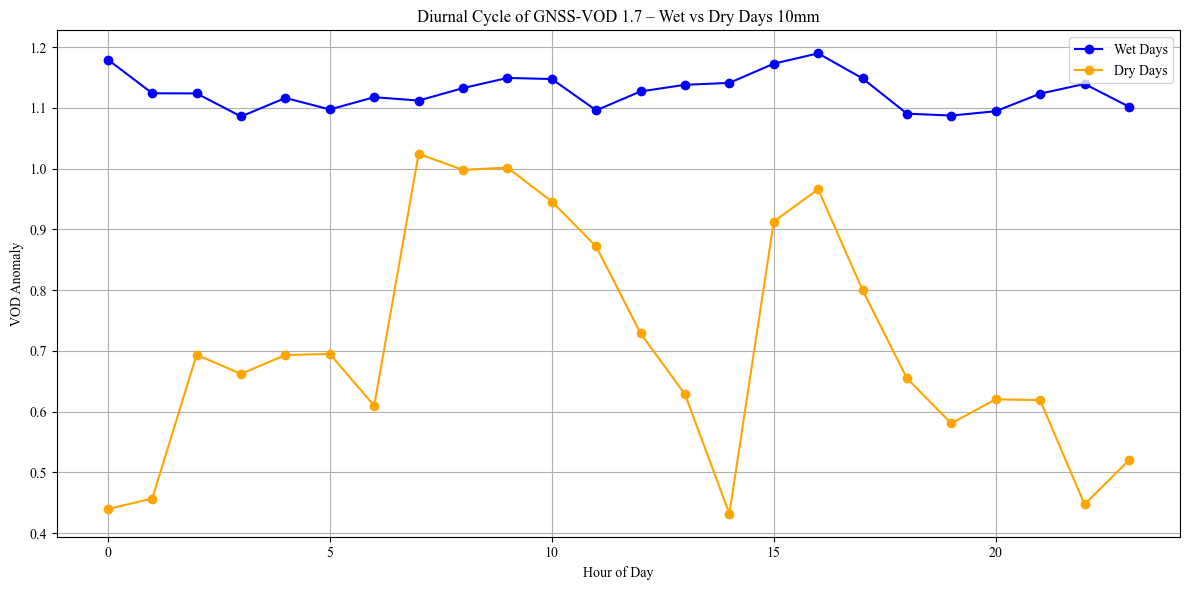

In [44]:
#
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()  # This keeps full datetime, just zeroes the time

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()


precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

#
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# 
vod_ts17.index = pd.to_datetime(vod_ts17.index)
vod_ts17['Date'] = vod_ts17.index.normalize()

vod_ts17['wetdry'] = 'none'
vod_ts17.loc[vod_ts17['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts17.loc[vod_ts17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# 
print(vod_ts17['wetdry'].value_counts())

# --- 3. Compute Diurnal Cycles ---
wet_data = vod_ts17[vod_ts17['wetdry'] == 'wet']
dry_data = vod_ts17[vod_ts17['wetdry'] == 'dry']

wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

#

plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))

wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')

ax.set_title("Diurnal Cycle of GNSS-VOD 1.7 – Wet vs Dry Days 10mm")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


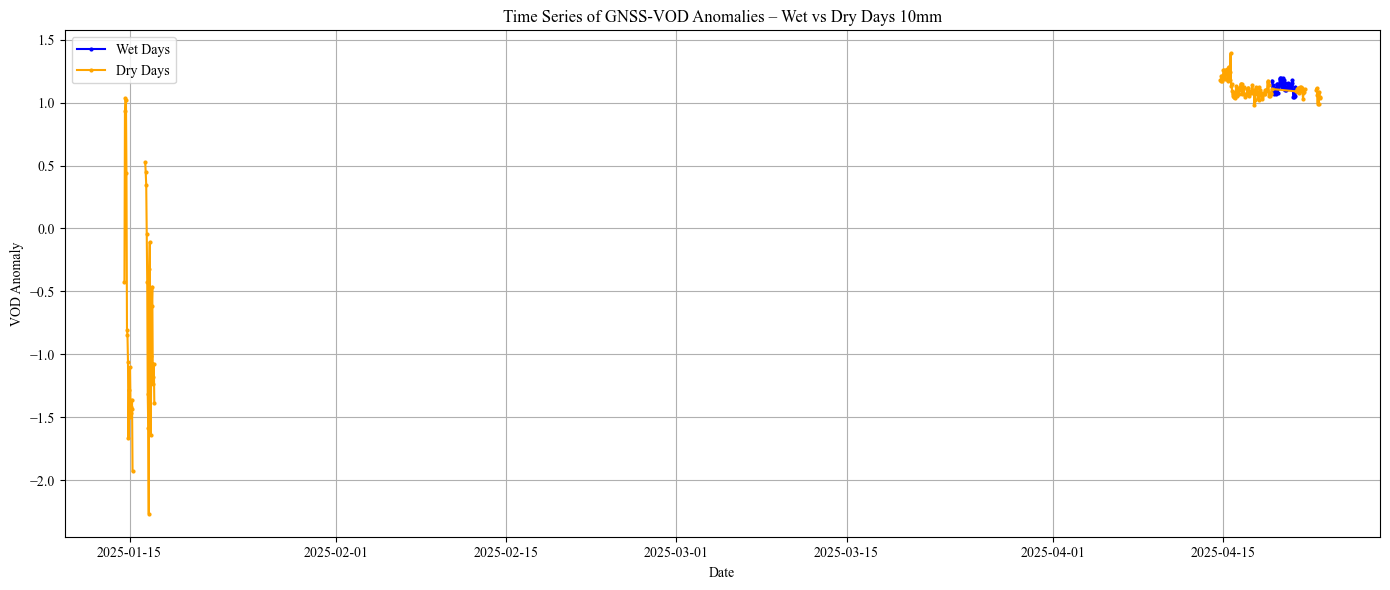

In [45]:
#
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

#
vod_ts17.index = pd.to_datetime(vod_ts17.index)
vod_ts17['Date'] = vod_ts17.index.normalize()

vod_ts17['wetdry'] = 'none'
vod_ts17.loc[vod_ts17['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts17.loc[vod_ts17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# 
wet_data = vod_ts17[vod_ts17['wetdry'] == 'wet']
dry_data = vod_ts17[vod_ts17['wetdry'] == 'dry']

#
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(wet_data.index, wet_data['VOD1_anom'], label='Wet Days', color='blue', linestyle='-', marker='o', markersize=2)
ax.plot(dry_data.index, dry_data['VOD1_anom'], label='Dry Days', color='orange', linestyle='-', marker='o', markersize=2)

ax.set_title("Time Series of GNSS-VOD Anomalies – Wet vs Dry Days 10mm")
ax.set_xlabel("Date")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


now reference one, station 3

In [46]:
ds13=xr.open_mfdataset('/Volumes/coraldelmar/all_data/MACROCOSM-1.3/*.nc',combine='nested',concat_dim='Epoch')
ds13

<xarray.Dataset> Size: 7GB
Dimensions:    (Station: 2, Epoch: 570651, SV: 123)
Coordinates:
  * Station    (Station) <U11 88B 'MACROCOSM-1' 'MACROCOSM-3'
  * SV         (SV) <U3 1kB 'C11' 'C12' 'C14' 'C19' ... 'R26' 'R27' 'S31' 'S33'
  * Epoch      (Epoch) datetime64[ns] 5MB 2023-01-10T19:07:30 ... 2025-06-09T...
Data variables:
    S1C        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    S1X        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    S2C        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    S2X        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    Azimuth    (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>
    Elevation  (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 15), meta=np.ndarray>

In [47]:
df13=ds13.to_dataframe().dropna(how='all').reorder_levels(["Station","Epoch","SV"]).sort_index()
df13

S1C  S1X   S2C  S2X  Azimuth  Elevation
Station     Epoch               SV                                           
MACROCOSM-1 2023-01-10 19:07:30 C35   NaN  NaN   NaN  NaN     99.5       62.1
                                G04  31.0  NaN   NaN  NaN    -76.2       58.1
                                G08  41.3  NaN   NaN  NaN   -144.5       66.0
                                G16  31.0  NaN   NaN  NaN     13.1       41.2
                                G26  27.7  NaN   NaN  NaN     48.2       21.9
...                                   ...  ...   ...  ...      ...        ...
MACROCOSM-3 2025-06-03 09:27:00 R10  21.0  NaN   NaN  NaN      NaN        NaN
                                R11  28.7  NaN  28.3  NaN      7.4       39.0
                                R20  25.6  NaN   NaN  NaN     27.8       17.3
                                R21  43.1  NaN  32.5  NaN     45.8       68.3
                                R22  43.5  NaN  28.9  NaN   -166.9       45.5

[16673307 rows x 6 columns]

In [48]:
hemi13 = gv.hemibuild(4)
hemi13

In [49]:
hemi13.grid

,azi,ele,azimin,azimax,elemin,elemax
CellID,,,,,,
0,0.000000,90.0,0.000000,360.000000,88.0,90.0
1,22.500000,86.0,0.000000,45.000000,84.0,88.0
2,67.500000,86.0,45.000000,90.000000,84.0,88.0
3,112.500000,86.0,90.000000,135.000000,84.0,88.0
4,157.500000,86.0,135.000000,180.000000,84.0,88.0
...,...,...,...,...,...,...
1523,345.789474,6.0,344.210526,347.368421,4.0,8.0
1524,348.947368,6.0,347.368421,350.526316,4.0,8.0
1525,352.105263,6.0,350.526316,353.684211,4.0,8.0


In [50]:
# get patches
patches13 = hemi13.patches() 
patches13

CellID
0       Rectangle(xy=(0, 0), width=6.28319, height=2, ...
1       Rectangle(xy=(0, 2), width=0.785398, height=4,...
2       Rectangle(xy=(0.785398, 2), width=0.785398, he...
3       Rectangle(xy=(1.5708, 2), width=0.785398, heig...
4       Rectangle(xy=(2.35619, 2), width=0.785398, hei...
                              ...                        
1523    Rectangle(xy=(6.00761, 82), width=0.0551157, h...
1524    Rectangle(xy=(6.06272, 82), width=0.0551157, h...
1525    Rectangle(xy=(6.11784, 82), width=0.0551157, h...
1526    Rectangle(xy=(6.17295, 82), width=0.0551157, h...
1527    Rectangle(xy=(6.22807, 82), width=0.0551157, h...
Name: Patches, Length: 1528, dtype: object

In [51]:
newdf13 = hemi13.add_CellID(df13)
newdf13

S1C  S1X   S2C  S2X  Azimuth  Elevation  \
Station     Epoch               SV                                              
MACROCOSM-1 2023-01-10 19:07:30 C35   NaN  NaN   NaN  NaN     99.5       62.1   
                                G04  31.0  NaN   NaN  NaN    -76.2       58.1   
                                G08  41.3  NaN   NaN  NaN   -144.5       66.0   
                                G16  31.0  NaN   NaN  NaN     13.1       41.2   
                                G26  27.7  NaN   NaN  NaN     48.2       21.9   
...                                   ...  ...   ...  ...      ...        ...   
MACROCOSM-3 2025-06-03 09:27:00 G30  32.9  NaN   NaN  NaN    -38.5       13.5   
                                R11  28.7  NaN  28.3  NaN      7.4       39.0   
                                R20  25.6  NaN   NaN  NaN     27.8       17.3   
                                R21  43.1  NaN  32.5  NaN     45.8       68.3   
                                R22  43.5  NaN  28.9  NaN   -166.9       45.5   

                                     CellID  
Station     Epoch               SV           
MACROCOSM-1 2023-01-10 19:07:30 C35     181  
                                G04     269  
                                G08     148  
                                G16     506  
                                G26     989  
...                                     ...  
MACROCOSM-3 2025-06-03 09:27:00 G30    1289  
                                R11     589  
                                R20    1089  
                                R21      85  
                                R22     465  

[15495779 rows x 7 columns]

In [52]:
hemi_average13 = newdf13.groupby(['CellID','Station']).mean()
hemi_average13

S1C        S1X        S2C        S2X    Azimuth  \
CellID Station                                                              
0      MACROCOSM-1  47.332554  45.248009  40.380218  45.327145  23.141237   
       MACROCOSM-3  42.948034  41.080195  35.502141  37.545359  31.075221   
1      MACROCOSM-1  46.597065  45.417704  39.954955  45.305258  24.148296   
       MACROCOSM-3  43.408105  41.666317  37.910960  41.209602  19.853254   
2      MACROCOSM-1  46.445706  45.421929  40.384750  45.773961  66.738849   
...                       ...        ...        ...        ...        ...   
1517   MACROCOSM-3  25.783638  23.687500  23.223681        NaN -33.357012   
1518   MACROCOSM-1  28.025272        NaN  24.501672        NaN -29.897271   
       MACROCOSM-3  25.306645        NaN  23.217862        NaN -30.034455   
1519   MACROCOSM-1  31.407289        NaN  25.329889        NaN -27.198941   
       MACROCOSM-3  26.458494        NaN  23.346693        NaN -27.169096   

                    Elevation  
CellID Station                 
0      MACROCOSM-1  88.636819  
       MACROCOSM-3  88.596740  
1      MACROCOSM-1  85.639587  
       MACROCOSM-3  85.855819  
2      MACROCOSM-1  85.824616  
...                       ...  
1517   MACROCOSM-3   6.580713  
1518   MACROCOSM-1   5.179076  
       MACROCOSM-3   5.192612  
1519   MACROCOSM-1   6.168022  
       MACROCOSM-3   6.172501  

[2897 rows x 6 columns]

In [53]:
# set which data files should be loaded
pattern = '/Volumes/coraldelmar/all_data/MACROCOSM-1.3/*.nc'
# define how to associate stations together. Always put reference station first.
pairings={'MACROCOSM-1.3':('MACROCOSM-1','MACROCOSM-3')}
# define if some observables with similar frequencies should be combined together. In the future, this should be replaced by the selection of frequency bands.
bands = {'VOD1':['S1','S1X','S1C'],'VOD2':['S2','S2X','S2C']}
vod13 = gv.calc_vod(pattern,pairings,bands)
vod13 = vod13['MACROCOSM-1.3']
vod13

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-04-22 15:06:00 C29       NaN       NaN     12.4       45.2
                    C35       NaN       NaN    -78.3       42.1
                    C36       NaN       NaN    154.2       46.4
                    E13  2.574204       NaN     22.6       66.4
                    E18  3.098924       NaN     24.2       45.1
...                           ...       ...      ...        ...
2025-04-26 23:59:30 R07  0.264317 -0.254151    -81.8       26.2
                    R20  2.347911  2.617344    170.9       56.7
                    R21  1.816098  1.020280    -46.6       62.4
                    R22  0.143130       NaN    -27.5        7.6
                    R27       NaN       NaN      NaN        NaN

[1072783 rows x 4 columns]

In [54]:
# intialize hemispheric grid
hemi13 = gv.hemibuild(2)
# get patches for plotting later
patches13 = hemi13.patches()
# classify vod into grid cells, drop azimuth and elevation afterwards as we don't need it anymore
vod13 = hemi13.add_CellID(vod13)
# get average value per grid cell
vod_avg13 = vod13.groupby(['CellID']).agg(['mean', 'std', 'count'])
# flatten the columns
vod_avg13.columns = ["_".join(x) for x in vod_avg13.columns.to_flat_index()]
vod_avg13

,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,Azimuth_mean,Azimuth_std,Azimuth_count,Elevation_mean,Elevation_std,Elevation_count
CellID,,,,,,,,,,,,
0,1.384395,0.552824,78,1.689120,0.509241,22,20.753774,96.781400,106,89.331132,0.184836,106
1,0.798258,0.453071,210,1.459434,0.519168,157,25.886522,9.769981,230,87.865217,0.520756,230
2,1.068360,0.421401,174,1.236276,0.721751,147,66.698507,12.856187,201,88.072637,0.571662,201
3,0.882420,0.439769,195,2.172158,0.755551,173,113.683491,13.171201,212,88.077358,0.482152,212
4,0.847916,0.501319,176,1.320035,0.619973,109,152.381373,13.256791,204,87.733333,0.526506,204
...,...,...,...,...,...,...,...,...,...,...,...,...
6427,0.002781,0.062069,8,0.016148,0.018065,2,-31.912500,0.235660,8,2.700000,0.226779,8
6428,-0.002975,0.032095,60,0.002497,0.057989,14,-30.271014,0.391491,69,1.814493,0.490281,69
6429,0.016802,0.054305,231,0.006552,0.037150,32,-29.003600,0.450376,250,2.211600,0.539806,250


In [55]:
# merge statistics with the original VOD measurements
vod_anom13 = vod13.join(vod_avg13,on='CellID')
vod_anom13

VOD1      VOD2  Azimuth  Elevation  CellID  \
Epoch               SV                                                    
2025-04-22 15:06:00 C29       NaN       NaN     12.4       45.2    1768   
                    C35       NaN       NaN    -78.3       42.1    2220   
                    C36       NaN       NaN    154.2       46.4    1831   
                    E13  2.574204       NaN     22.6       66.4     527   
                    E18  3.098924       NaN     24.2       45.1    1773   
...                           ...       ...      ...        ...     ...   
2025-04-26 23:59:30 R05  0.681749       NaN     36.3        8.6    5557   
                    R07  0.264317 -0.254151    -81.8       26.2    3742   
                    R20  2.347911  2.617344    170.9       56.7    1119   
                    R21  1.816098  1.020280    -46.6       62.4     809   
                    R22  0.143130       NaN    -27.5        7.6    5744   

                         VOD1_mean  VOD1_std  VOD1_count  VOD2_mean  VOD2_std  \
Epoch               SV                                                          
2025-04-22 15:06:00 C29   1.509036  0.604288         378   1.203316  0.371469   
                    C35   0.114970  0.719658          91   0.496318  0.302004   
                    C36   2.141441  0.700743         109   1.903478  0.690526   
                    E13   2.825693  0.912938          98   2.733274  1.317678   
                    E18   1.636003  0.676913         405   1.251350  0.626799   
...                            ...       ...         ...        ...       ...   
2025-04-26 23:59:30 R05   0.203581  0.166938         124   0.070259  0.195897   
                    R07  -0.080797  0.587262         108   0.242109  0.515559   
                    R20   3.100019  0.763806         143   1.990623  0.499145   
                    R21   1.248028  0.698056         258   1.437374  0.558447   
                    R22   0.281978  0.182611         300   0.291384  0.143672   

                         VOD2_count  Azimuth_mean  Azimuth_std  Azimuth_count  \
Epoch               SV                                                          
2025-04-22 15:06:00 C29         227     12.529231     0.634244            520   
                    C35          32    -77.320000     0.601340            170   
                    C36          58    154.988820     0.685383            161   
                    E13           5     21.582069     1.116646            145   
                    E18         227     23.688132     0.651461            514   
...                             ...           ...          ...            ...   
2025-04-26 23:59:30 R05          16     35.776151     0.322504            239   
                    R07          54    -81.289262     0.517157            149   
                    R20         115    170.395210     0.599579            167   
                    R21         146    -45.302083     0.967206            336   
                    R22         213    -27.552117     0.350379            307   

                         Elevation_mean  Elevation_std  Elevation_count  
Epoch               SV                                                   
2025-04-22 15:06:00 C29       46.056731       0.548244              520  
                    C35       41.909412       0.490772              170  
                    C36       45.973913       0.551421              161  
                    E13       66.032414       0.575529              145  
                    E18       45.870623       0.607180              514  
...                                 ...            ...              ...  
2025-04-26 23:59:30 R05        8.094142       0.559756              239  
                    R07       26.281208       0.454463              149  
                    R20       56.108982       0.574438              167  
                    R21       61.887202       0.567621              336  
                    R22        8.036482       0.570894   

In [56]:
vod_anom13['VOD1_anom'] = vod_anom13['VOD1']-vod_anom13['VOD1_mean']
vod_anom13['VOD2_anom'] = vod_anom13['VOD2']-vod_anom13['VOD2_mean']

In [57]:
vod_ts13 = vod_anom13.groupby(pd.Grouper(freq='1h', level='Epoch')).mean()
vod_ts13

,VOD1,VOD2,Azimuth,Elevation,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,Azimuth_mean,Azimuth_std,Azimuth_count,Elevation_mean,Elevation_std,Elevation_count,VOD1_anom,VOD2_anom
Epoch,,,,,,,,,,,,,,,,,,,
2025-04-14 18:00:00,0.937676,1.121445,-8.194943,39.035707,2571.789474,1.043548,0.552777,241.498452,0.862905,0.515585,123.512900,-8.195364,0.608209,309.481940,39.042641,0.542802,309.481940,-0.017359,-0.005085
2025-04-14 19:00:00,1.152568,1.304019,2.588902,37.978689,2639.296951,1.095023,0.544870,216.803963,1.051100,0.535000,107.234756,2.361845,1.995537,285.451220,37.983267,0.538850,285.451220,-0.030209,-0.026501
2025-04-14 20:00:00,1.282368,1.125101,9.822427,42.355903,2313.864189,1.221453,0.573940,240.848076,1.125569,0.544446,130.558369,9.829461,0.945463,308.294640,42.380136,0.543217,308.294640,0.011075,-0.034397
2025-04-14 21:00:00,1.153162,1.056868,18.928424,39.136481,2591.536900,1.191249,0.547994,255.587818,1.104843,0.518046,125.592330,18.919256,0.654277,325.976474,39.130798,0.545692,325.976474,-0.032772,0.009419
2025-04-14 22:00:00,1.077965,0.928773,10.298809,41.507555,2458.211388,1.140353,0.558791,255.163751,0.987457,0.536055,130.597320,10.312319,0.751568,327.187198,41.498066,0.542150,327.187198,0.019025,0.091423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03 05:00:00,1.280750,1.255588,7.921360,38.978364,2633.819876,1.288823,0.561069,287.727743,1.116377,0.522559,145.323671,8.623834,1.715526,364.797447,38.991707,0.552133,364.797447,-0.085561,0.059681
2025-06-03 06:00:00,1.266572,1.143270,3.670944,39.284062,2584.127060,1.123857,0.561569,242.716730,1.037361,0.538647,120.901141,3.673283,0.657628,317.064322,39.261486,0.550071,317.064322,0.013854,0.081459
2025-06-03 07:00:00,0.878284,0.845433,-9.584544,37.964236,2725.630310,0.943807,0.524440,237.246460,0.876494,0.502418,114.332329,-9.572247,0.675234,308.702923,37.976253,0.542800,308.702923,-0.043775,0.018295


In [58]:
vod_ts13['VOD1_anom'] = vod_ts13['VOD1_anom']+vod_ts13['VOD1'].mean()
vod_ts13['VOD2_anom'] = vod_ts13['VOD2_anom']+vod_ts13['VOD2'].mean()

wetdry
none    994
dry     150
wet      48
Name: count, dtype: int64


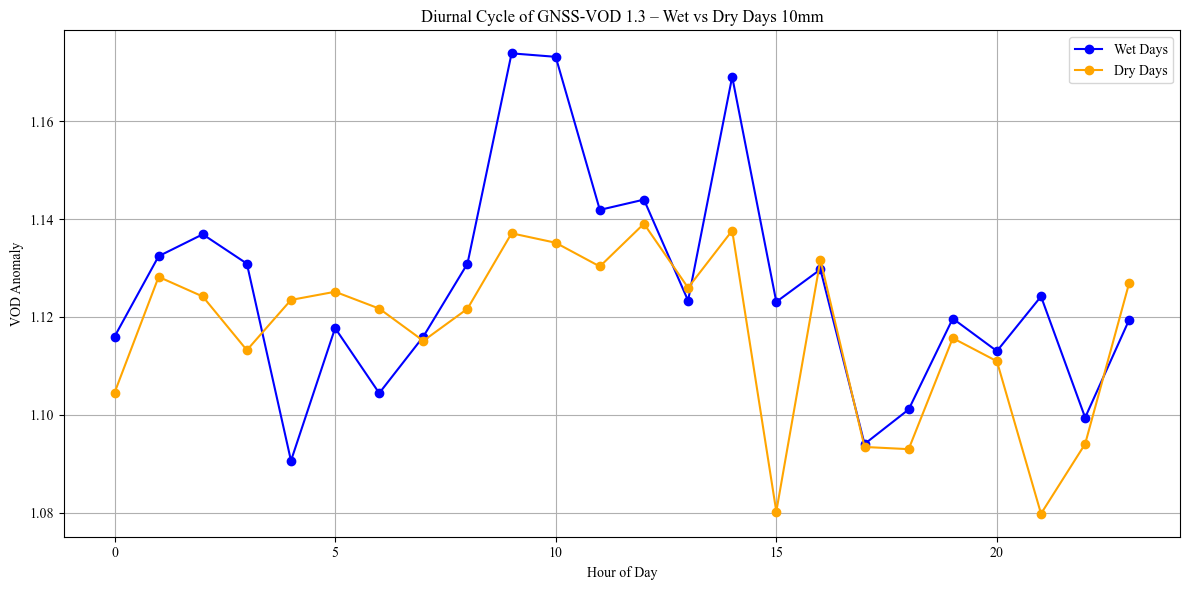

In [59]:
#
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()  # This keeps full datetime, just zeroes the time

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()

# 
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

# Define wet/dry
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# 
vod_ts13.index = pd.to_datetime(vod_ts13.index)
vod_ts13['Date'] = vod_ts13.index.normalize()

vod_ts13['wetdry'] = 'none'
vod_ts13.loc[vod_ts13['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts13.loc[vod_ts13['Date'].isin(dry_days), 'wetdry'] = 'dry'

#  
print(vod_ts13['wetdry'].value_counts())

#  
wet_data = vod_ts13[vod_ts13['wetdry'] == 'wet']
dry_data = vod_ts13[vod_ts13['wetdry'] == 'dry']

wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

#
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))

wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')

ax.set_title("Diurnal Cycle of GNSS-VOD 1.3 – Wet vs Dry Days 10mm")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


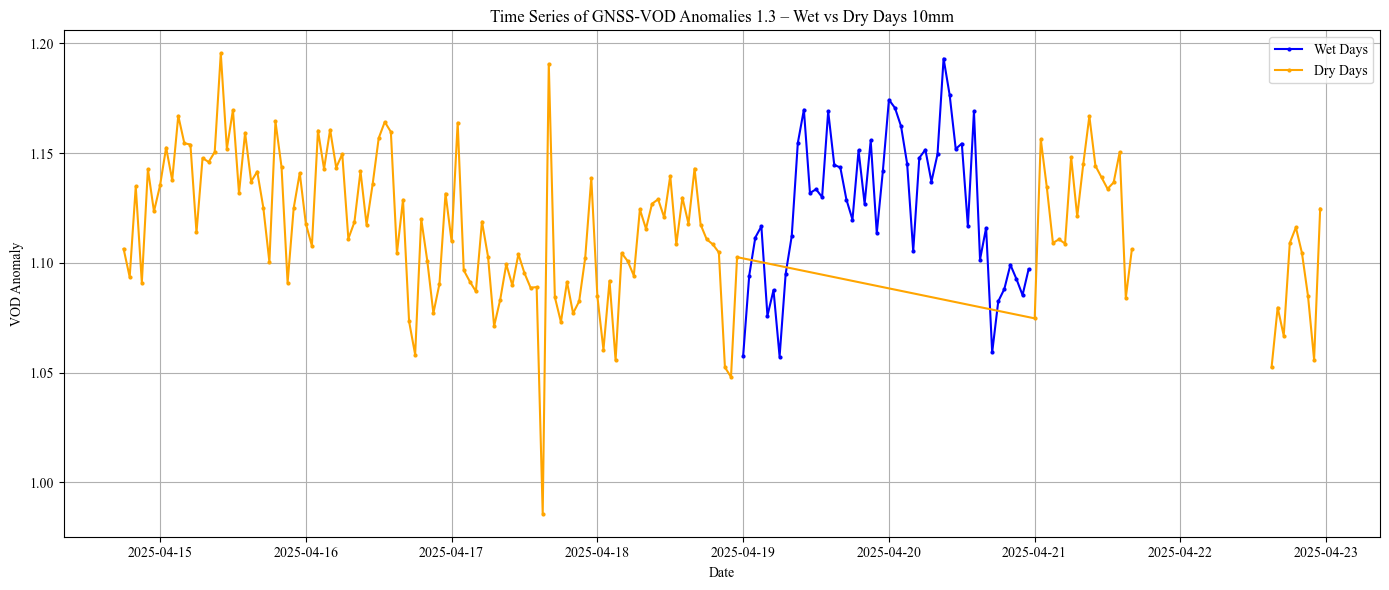

In [60]:
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# 
vod_ts13.index = pd.to_datetime(vod_ts13.index)
vod_ts13['Date'] = vod_ts13.index.normalize()

vod_ts13['wetdry'] = 'none'
vod_ts13.loc[vod_ts13['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts13.loc[vod_ts13['Date'].isin(dry_days), 'wetdry'] = 'dry'

# 
wet_data = vod_ts13[vod_ts13['wetdry'] == 'wet']
dry_data = vod_ts13[vod_ts13['wetdry'] == 'dry']

# 
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(wet_data.index, wet_data['VOD1_anom'], label='Wet Days', color='blue', linestyle='-', marker='o', markersize=2)
ax.plot(dry_data.index, dry_data['VOD1_anom'], label='Dry Days', color='orange', linestyle='-', marker='o', markersize=2)

ax.set_title("Time Series of GNSS-VOD Anomalies 1.3 – Wet vs Dry Days 10mm")
ax.set_xlabel("Date")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

now reference 1 and station 2

In [61]:
ds12=xr.open_mfdataset('/Volumes/coraldelmar/all_data/MACROCOSM-1.2/*.nc',combine='nested',concat_dim='Epoch')
ds12

<xarray.Dataset> Size: 8GB
Dimensions:    (Station: 2, Epoch: 707868, SV: 123)
Coordinates:
  * Station    (Station) <U11 88B 'MACROCOSM-1' 'MACROCOSM-2'
  * SV         (SV) <U3 1kB 'C11' 'C12' 'C14' 'C19' ... 'R26' 'R27' 'S31' 'S33'
  * Epoch      (Epoch) datetime64[ns] 6MB 2023-01-10T19:07:30 ... 2025-06-09T...
Data variables:
    S1C        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 14), meta=np.ndarray>
    S1X        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 14), meta=np.ndarray>
    S2C        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 14), meta=np.ndarray>
    S2X        (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 14), meta=np.ndarray>
    Azimuth    (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 14), meta=np.ndarray>
    Elevation  (Station, Epoch, SV) float64 1GB dask.array<chunksize=(1, 585, 14), meta=np.ndarray>

In [62]:
df12=ds12.to_dataframe().dropna(how='all').reorder_levels(["Station","Epoch","SV"]).sort_index()
df12

S1C  S1X  S2C  S2X  Azimuth  Elevation
Station     Epoch               SV                                          
MACROCOSM-1 2023-01-10 19:07:30 C35   NaN  NaN  NaN  NaN     99.5       62.1
                                G04  31.0  NaN  NaN  NaN    -76.2       58.1
                                G08  41.3  NaN  NaN  NaN   -144.5       66.0
                                G16  31.0  NaN  NaN  NaN     13.1       41.2
                                G26  27.7  NaN  NaN  NaN     48.2       21.9
...                                   ...  ...  ...  ...      ...        ...
MACROCOSM-2 2025-06-03 16:06:00 G20  28.9  NaN  NaN  NaN   -106.8       53.3
                                G22  27.0  NaN  NaN  NaN    179.5       36.7
                                R01  29.3  NaN  NaN  NaN      NaN        NaN
                                R02  32.1  NaN  NaN  NaN    157.2       47.1
                                R14  22.4  NaN  NaN  NaN   -113.6       31.4

[23094918 rows x 6 columns]

In [63]:
hemi12 = gv.hemibuild(4)
hemi12

In [64]:
hemi12.grid

,azi,ele,azimin,azimax,elemin,elemax
CellID,,,,,,
0,0.000000,90.0,0.000000,360.000000,88.0,90.0
1,22.500000,86.0,0.000000,45.000000,84.0,88.0
2,67.500000,86.0,45.000000,90.000000,84.0,88.0
3,112.500000,86.0,90.000000,135.000000,84.0,88.0
4,157.500000,86.0,135.000000,180.000000,84.0,88.0
...,...,...,...,...,...,...
1523,345.789474,6.0,344.210526,347.368421,4.0,8.0
1524,348.947368,6.0,347.368421,350.526316,4.0,8.0
1525,352.105263,6.0,350.526316,353.684211,4.0,8.0


In [65]:
# get patches
patches12 = hemi12.patches() 
patches12

CellID
0       Rectangle(xy=(0, 0), width=6.28319, height=2, ...
1       Rectangle(xy=(0, 2), width=0.785398, height=4,...
2       Rectangle(xy=(0.785398, 2), width=0.785398, he...
3       Rectangle(xy=(1.5708, 2), width=0.785398, heig...
4       Rectangle(xy=(2.35619, 2), width=0.785398, hei...
                              ...                        
1523    Rectangle(xy=(6.00761, 82), width=0.0551157, h...
1524    Rectangle(xy=(6.06272, 82), width=0.0551157, h...
1525    Rectangle(xy=(6.11784, 82), width=0.0551157, h...
1526    Rectangle(xy=(6.17295, 82), width=0.0551157, h...
1527    Rectangle(xy=(6.22807, 82), width=0.0551157, h...
Name: Patches, Length: 1528, dtype: object

In [66]:
newdf12 = hemi12.add_CellID(df12)
newdf12

S1C  S1X  S2C  S2X  Azimuth  Elevation  \
Station     Epoch               SV                                             
MACROCOSM-1 2023-01-10 19:07:30 C35   NaN  NaN  NaN  NaN     99.5       62.1   
                                G04  31.0  NaN  NaN  NaN    -76.2       58.1   
                                G08  41.3  NaN  NaN  NaN   -144.5       66.0   
                                G16  31.0  NaN  NaN  NaN     13.1       41.2   
                                G26  27.7  NaN  NaN  NaN     48.2       21.9   
...                                   ...  ...  ...  ...      ...        ...   
MACROCOSM-2 2025-06-03 16:06:00 G19  30.7  NaN  NaN  NaN     66.0       60.4   
                                G20  28.9  NaN  NaN  NaN   -106.8       53.3   
                                G22  27.0  NaN  NaN  NaN    179.5       36.7   
                                R02  32.1  NaN  NaN  NaN    157.2       47.1   
                                R14  22.4  NaN  NaN  NaN   -113.6       31.4   

                                     CellID  
Station     Epoch               SV           
MACROCOSM-1 2023-01-10 19:07:30 C35     181  
                                G04     269  
                                G08     148  
                                G16     506  
                                G26     989  
...                                     ...  
MACROCOSM-2 2025-06-03 16:06:00 G19     176  
                                G20     329  
                                G22     632  
                                R02     457  
                                R14     840  

[21594633 rows x 7 columns]

In [67]:
hemi_average12 = newdf12.groupby(['CellID','Station']).mean()
hemi_average12

S1C        S1X        S2C        S2X    Azimuth  \
CellID Station                                                              
0      MACROCOSM-1  47.332554  45.248009  40.380218  45.327145  23.141237   
       MACROCOSM-2  41.310546  40.992655  34.428664  41.472801  30.283349   
1      MACROCOSM-1  46.597065  45.417704  39.954955  45.305258  24.148296   
       MACROCOSM-2  40.938648  39.481029  35.151039  40.678191  22.537117   
2      MACROCOSM-1  46.445706  45.421929  40.384750  45.773961  66.738849   
...                       ...        ...        ...        ...        ...   
1517   MACROCOSM-2  26.202456  25.093638  21.807977        NaN -33.378799   
1518   MACROCOSM-1  28.025272        NaN  24.501672        NaN -29.897271   
       MACROCOSM-2  24.856138        NaN  21.643866        NaN -30.013319   
1519   MACROCOSM-1  31.407289        NaN  25.329889        NaN -27.198941   
       MACROCOSM-2  25.133699        NaN  21.051628        NaN -27.216654   

                    Elevation  
CellID Station                 
0      MACROCOSM-1  88.636819  
       MACROCOSM-2  88.625538  
1      MACROCOSM-1  85.639587  
       MACROCOSM-2  85.714684  
2      MACROCOSM-1  85.824616  
...                       ...  
1517   MACROCOSM-2   6.571973  
1518   MACROCOSM-1   5.179076  
       MACROCOSM-2   5.152819  
1519   MACROCOSM-1   6.168022  
       MACROCOSM-2   6.143685  

[2906 rows x 6 columns]

In [68]:
hemi_average12[['S1C', 'S1X', 'S2X']].isna().sum()
hemi_average12 = hemi_average12.dropna(subset=['S1C','S1X','S2C','S2X'])

In [69]:
hemi_average12

S1C        S1X        S2C        S2X    Azimuth  \
CellID Station                                                              
0      MACROCOSM-1  47.332554  45.248009  40.380218  45.327145  23.141237   
       MACROCOSM-2  41.310546  40.992655  34.428664  41.472801  30.283349   
1      MACROCOSM-1  46.597065  45.417704  39.954955  45.305258  24.148296   
       MACROCOSM-2  40.938648  39.481029  35.151039  40.678191  22.537117   
2      MACROCOSM-1  46.445706  45.421929  40.384750  45.773961  66.738849   
...                       ...        ...        ...        ...        ...   
1514   MACROCOSM-2  25.228914  24.278366  16.544444  20.859044 -42.600825   
1515   MACROCOSM-1  31.495989  30.029118  25.435021  26.846600 -39.264525   
       MACROCOSM-2  25.019842  24.729960  20.940678  21.583442 -39.146895   
1516   MACROCOSM-1  28.893129  27.462854  24.060313  24.407587 -36.627167   
       MACROCOSM-2  25.329999  25.076490  22.549620  21.743949 -36.628984   

                    Elevation  
CellID Station                 
0      MACROCOSM-1  88.636819  
       MACROCOSM-2  88.625538  
1      MACROCOSM-1  85.639587  
       MACROCOSM-2  85.714684  
2      MACROCOSM-1  85.824616  
...                       ...  
1514   MACROCOSM-2   6.120839  
1515   MACROCOSM-1   6.214502  
       MACROCOSM-2   6.342242  
1516   MACROCOSM-1   6.033766  
       MACROCOSM-2   6.068040  

[2235 rows x 6 columns]

In [70]:
# set which data files should be loaded
pattern = '/Volumes/coraldelmar/all_data/MACROCOSM-1.2/*.nc'
# define how to associate stations together. Always put reference station first.
pairings={'MACROCOSM-1.2':('MACROCOSM-1','MACROCOSM-2')}
# define if some observables with similar frequencies should be combined together. In the future, this should be replaced by the selection of frequency bands.
bands = {'VOD1':['S1','S1X','S1C'],'VOD2':['S2','S2X','S2C']}
vod12 = gv.calc_vod(pattern,pairings,bands)
vod12 = vod12['MACROCOSM-1.2']
vod12

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-05-26 00:00:00 C20       NaN       NaN    -54.8       14.5
                    C23       NaN       NaN     80.9       50.4
                    C25       NaN       NaN     43.1       11.1
                    C27       NaN       NaN   -162.1       26.0
                    C30       NaN       NaN   -103.1       30.6
...                           ...       ...      ...        ...
2023-03-07 23:59:30 R05  2.762282  1.704387    144.3       58.3
                    R09 -0.175271  1.185654   -119.8       26.6
                    R10       NaN       NaN      NaN        NaN
                    R19  1.371955  0.941093     39.7       29.5
                    R20 -0.000000  0.433362    -27.8       20.8

[3704019 rows x 4 columns]

In [71]:
vod12[['VOD1','VOD2']].isna().sum()
vod12 = vod12.dropna(subset=['VOD1','VOD2'])
vod12

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-05-26 00:00:00 G18  2.536817  1.402468   -138.0       63.6
                    G23  3.047275  2.527009      3.2       53.8
                    G24  0.612687  1.802022     34.7       51.5
                    G32  0.732751 -0.049960    -79.1       21.2
                    R04  1.801443  2.413472     -7.3       30.1
...                           ...       ...      ...        ...
2023-03-07 23:59:30 R04  2.426857  2.075602     51.6       43.9
                    R05  2.762282  1.704387    144.3       58.3
                    R09 -0.175271  1.185654   -119.8       26.6
                    R19  1.371955  0.941093     39.7       29.5
                    R20 -0.000000  0.433362    -27.8       20.8

[1345627 rows x 4 columns]

In [72]:
hemi12=gv.hemibuild(2)
patches12=hemi12.patches()
vod12=hemi12.add_CellID(vod12).drop(columns=['Azimuth','Elevation'])
vod_avg12=vod12.groupby(['CellID']).agg(['mean','std','count'])
vod_avg12.columns=["_".join(x) for x in vod_avg12.columns.to_flat_index()]
vod_avg12

,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count
CellID,,,,,,
0,1.266048,0.593741,87,1.160455,0.642125,87
1,1.439105,0.601271,422,0.952427,0.571516,422
2,1.665521,0.804102,386,1.049723,0.486886,386
3,1.398637,0.773508,452,1.352150,0.646217,452
4,1.409815,0.731565,310,1.099626,0.731234,310
...,...,...,...,...,...,...
6427,0.011947,0.034889,5,0.010380,0.016280,5
6428,0.019098,0.040436,27,-0.004950,0.051429,27
6429,0.189596,0.494675,84,0.214553,0.537083,84


In [73]:
vod_anom12=vod12.join(vod_avg12,on='CellID')
vod_anom12

VOD1      VOD2  CellID  VOD1_mean  VOD1_std  \
Epoch               SV                                                     
2025-05-26 00:00:00 G18  2.536817  1.402468     676   2.492852  0.893779   
                    G23  3.047275  2.527009    1188   2.322250  0.801293   
                    G24  0.612687  1.802022    1335   0.820956  0.615576   
                    G32  0.732751 -0.049960    4163   0.138001  0.522446   
                    R04  1.801443  2.413472    3376   1.434544  0.473547   
...                           ...       ...     ...        ...       ...   
2023-03-07 23:59:30 R04  2.426857  2.075602    1945   1.205136  0.853876   
                    R05  2.762282  1.704387     986   1.681649  0.624925   
                    R09 -0.175271  1.185654    3720  -0.217939  0.650735   
                    R19  1.371955  0.941093    3204   1.002401  0.589039   
                    R20 -0.000000  0.433362    4408   0.963543  0.413546   

                         VOD1_count  VOD2_mean  VOD2_std  VOD2_count  
Epoch               SV                                                
2025-05-26 00:00:00 G18         631   1.883608  0.822191         631  
                    G23         661   2.768915  0.816686         661  
                    G24         855   1.442984  0.597470         855  
                    G32         158   0.347544  0.496138         158  
                    R04         947   1.256769  0.497001         947  
...                             ...        ...       ...         ...  
2023-03-07 23:59:30 R04         463   1.906656  0.953770         463  
                    R05         218   2.106605  0.892269         218  
                    R09         126  -0.145407  0.832457         126  
                    R19         795   0.654969  0.457754         795  
                    R20         446   0.723000  0.376336         446  

[1343324 rows x 9 columns]

In [74]:
vod_anom12['VOD1_anom'] = vod_anom12['VOD1']-vod_anom12['VOD1_mean']
vod_anom12['VOD2_anom'] = vod_anom12['VOD2']-vod_anom12['VOD2_mean']

In [75]:
vod_ts12 = vod_anom12.groupby(pd.Grouper(freq='1h', level='Epoch')).mean()
vod_ts12

,VOD1,VOD2,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,VOD1_anom,VOD2_anom
Epoch,,,,,,,,,,,
2023-01-14 13:00:00,1.322702,1.159914,2102.441304,1.253808,0.730895,447.997826,1.259598,0.712229,447.997826,0.068893,-0.099684
2023-01-14 14:00:00,1.386727,1.331629,1957.881500,1.309946,0.782663,472.499574,1.241121,0.782568,472.499574,0.076781,0.090508
2023-01-14 15:00:00,1.326683,1.169586,2118.718023,1.460977,0.697066,471.577519,1.430310,0.694249,471.577519,-0.134294,-0.260724
2023-01-14 16:00:00,1.046428,1.012971,2829.732246,1.110741,0.628716,486.733205,1.082369,0.627443,486.733205,-0.064314,-0.069398
2023-01-14 17:00:00,1.266344,1.183543,3077.571554,1.132999,0.584250,595.975417,1.100199,0.580946,595.975417,0.133345,0.083344
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03 12:00:00,1.323272,1.454747,2043.711730,1.386694,0.750595,509.349901,1.421695,0.718739,509.349901,-0.063422,0.033052
2025-06-03 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-03 14:00:00,2.078921,2.564773,1912.607287,0.837158,0.695160,641.874494,0.823427,0.691452,641.874494,1.241763,1.741346


In [76]:
vod_ts12['VOD1_anom'] = vod_ts12['VOD1_anom']+vod_ts12['VOD1'].mean()
vod_ts12['VOD2_anom'] = vod_ts12['VOD2_anom']+vod_ts12['VOD2'].mean()

In [77]:
vod_ts12['VOD1'].mean()

1.2060080184831197

wetdry
none    18220
dry      1872
wet       816
Name: count, dtype: int64


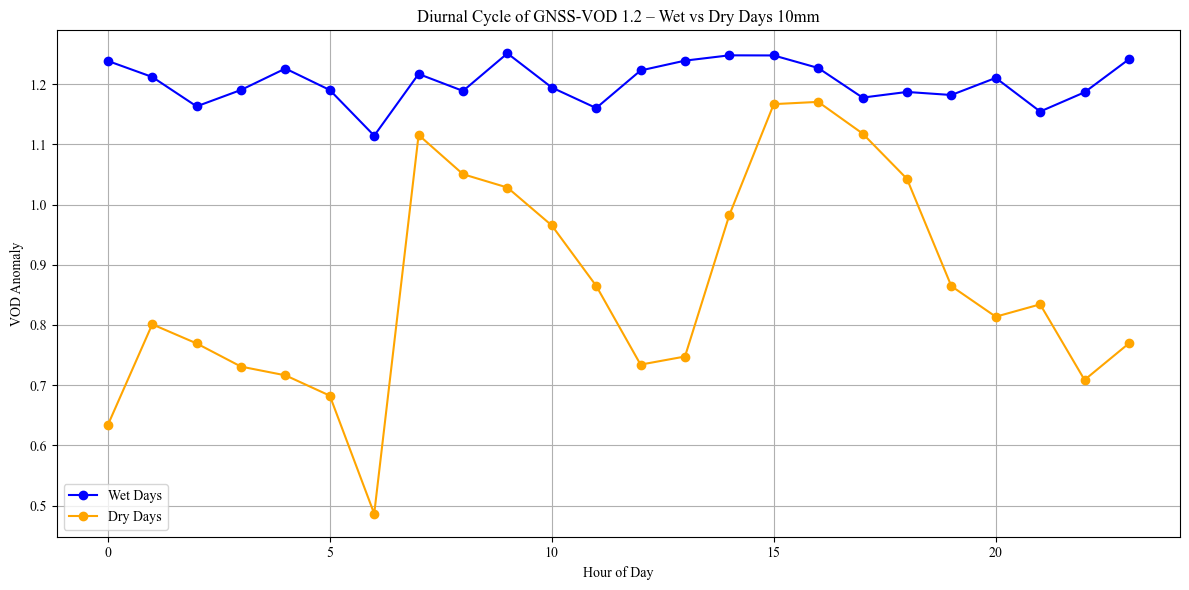

In [78]:
# 
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()  # This keeps full datetime, just zeroes the time

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()

# 
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

# 
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# 
vod_ts12.index = pd.to_datetime(vod_ts12.index)
vod_ts12['Date'] = vod_ts12.index.normalize()

vod_ts12['wetdry'] = 'none'
vod_ts12.loc[vod_ts12['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts12.loc[vod_ts12['Date'].isin(dry_days), 'wetdry'] = 'dry'

# 
print(vod_ts12['wetdry'].value_counts())

# 
wet_data = vod_ts12[vod_ts12['wetdry'] == 'wet']
dry_data = vod_ts12[vod_ts12['wetdry'] == 'dry']

wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

#

plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))

wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')

ax.set_title("Diurnal Cycle of GNSS-VOD 1.2 – Wet vs Dry Days 10mm")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

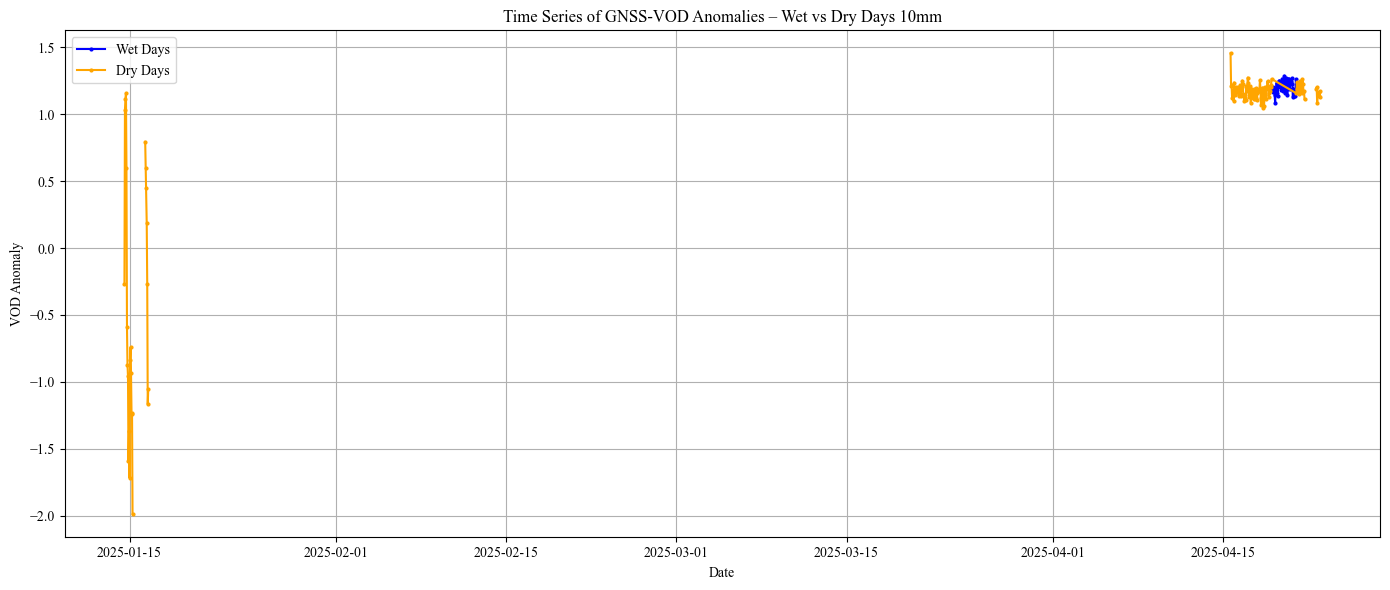

In [79]:

precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()

precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()
precip_daily['Date'] = pd.to_datetime(precip_daily['Date'])

wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# 
vod_ts12.index = pd.to_datetime(vod_ts12.index)
vod_ts12['Date'] = vod_ts12.index.normalize()

vod_ts12['wetdry'] = 'none'
vod_ts12.loc[vod_ts12['Date'].isin(wet_days), 'wetdry'] = 'wet'
vod_ts12.loc[vod_ts12['Date'].isin(dry_days), 'wetdry'] = 'dry'
#
wet_data = vod_ts12[vod_ts12['wetdry'] == 'wet']
dry_data = vod_ts12[vod_ts12['wetdry'] == 'dry']

# 
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(wet_data.index, wet_data['VOD1_anom'], label='Wet Days', color='blue', linestyle='-', marker='o', markersize=2)
ax.plot(dry_data.index, dry_data['VOD1_anom'], label='Dry Days', color='orange', linestyle='-', marker='o', markersize=2)

ax.set_title("Time Series of GNSS-VOD Anomalies – Wet vs Dry Days 10mm")
ax.set_xlabel("Date")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()